# Import Packages

In [553]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.model_selection import TimeSeriesSplit

from scipy.stats import spearmanr

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

# Useful Functions

## Plotting and Metric Score

In [554]:
def plot_ts(ts_x: pd.Series, ts_y: pd.Series, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()


def metric_train(output, Y_clean):
    return 100 * (spearmanr(output, Y_clean).correlation)

## Cross Valdiation for Maximum Metric Score using XGBRegressor

In [555]:
def XGBRegressorCrossValidationMetricScore(X_clean, Y_clean):
    """ Cross Validation for Metric Score: Maximising Spearman Correlation"""
    # Create a scorer from the custom metric function
    spearman_scorer = make_scorer(metric_train, greater_is_better=True)

    # Define your parameter grid
    param_grid = {
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'max_depth': [10, 12, 15],
        'alpha': [5, 10, 15],
        'n_estimators': [50, 100, 200]
    }

    # Initialize your model
    xgb_reg = XGBRegressor(objective='reg:squarederror')

    # Setup GridSearchCV or RandomizedSearchCV with your custom scorer
    cv_method = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5,
                            scoring=spearman_scorer, verbose=2, n_jobs=-1)

    # Assuming X_clean and Y_clean are already defined and preprocessed
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.20, random_state=42)

    # Fit the model to find the best parameters
    cv_method.fit(X_train, y_train)

    # Best parameters found
    print("Best parameters found: ", cv_method.best_params_)

    # Predict on the test set with the best parameters
    y_pred = cv_method.predict(X_test)

    # Calculate MSE on the test set and then convert to RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Test set RMSE: {:.2f}'.format(rmse))


    training_prediction = cv_method.predict(X_clean)

    # Calculate Spearman correlation on the test set
    test_spearman_correlation = metric_train(y_test, y_pred) 
    print('Test set Spearman correlation: {:.1f}%'.format(test_spearman_correlation))

    result = {
        "parameters": cv_method.best_params_,
        "RMSE": rmse,
        "Training Prediction":training_prediction,
        "Metric Score": test_spearman_correlation,
        "model":cv_method
    }
    return result

## Cross Validation for MSE using XGBRegressor

In [556]:
# Cross Validation for MSE using XGBRegressor
def XGBRegressorCrossValidationMSE(X_clean, Y_clean):
    """ Return the Cross Validated Prameters for XGBRegressor for MSE"""
    # X_clean and Y_clean must be processed already
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.25, random_state=42)

    # Standardize each data set
    X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

    # Define  parameter grid
    param_grid = {
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'max_depth': [10, 12, 15],
        'alpha': [5, 10, 15],
        'n_estimators': [50, 100, 200]
    }

    xgb_reg = XGBRegressor(objective='reg:squarederror')

    # SGridSearchCV with the scoring minimizing MSE
    cv_method = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5,
                            scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    cv_method.fit(X_train, y_train)

    # Best parameters 
    print("Best parameters found: ", cv_method.best_params_)

    # Predict on the test set with the best parameters
    y_pred = cv_method.predict(X_test)

    # Calculate MSE on the test set and then convert to RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Test set RMSE: {:.2f}'.format(rmse))

    training_prediction = cv_method.predict(X_clean)

    print('Cross Validated Model Spearman correlation for the train set: {:.1f}%'.format(metric_train(training_prediction, Y_clean)))

    result = {
        "parameters": cv_method.best_params_,
        "RMSE": rmse,
        "Training Prediction":training_prediction,
        "Metric Score": metric_train(training_prediction, Y_clean),
        "model":cv_method
    }
    return result

## Time Series Cross Validation

In [557]:
# Cross Validation for MSE using XGBRegressor with Time Series Split
def XGBRegressorTimeSeriesCV(X, y, n_splits=5):
    """ Return the Cross Validated Parameters for XGBRegressor using Time Series CV for MSE"""
    
    # TimeSeriesSplit provides train/test indices to split time series data samples
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Define parameter grid
    param_grid = {
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'max_depth': [10, 12, 15],
        'alpha': [5, 10, 15],
        'n_estimators': [50, 100, 200]
    }

    xgb_reg = XGBRegressor(objective='reg:squarederror')

    # GridSearchCV with the scoring minimizing MSE and TimeSeriesSplit
    cv_method = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=tscv,
                             scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    cv_method.fit(X, y)

    # Best parameters
    print("Best parameters found: ", cv_method.best_params_)

    # Predict with the best parameters
    # Note: TimeSeriesSplit doesn't explicitly create a global "test" set, you would typically use
    # the last fold's test set or create a separate test set outside of the cross-validation process.
    y_pred = cv_method.predict(X)

    # Calculate MSE and then convert to RMSE
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    print('RMSE: {:.2f}'.format(rmse))

    print('Cross Validated Model Spearman correlation: {:.1f}%'.format(metric_train(y_pred, y) * 100))

    result = {
        "parameters": cv_method.best_params_,
        "RMSE": rmse,
        "Training Prediction": y_pred,
        "Metric Score": metric_train(y_pred, y),
        "model": cv_method
    }
    return result

# Usage example:
# result = XGBRegressorTimeSeriesCV(X_clean, Y_clean)
# print(result)


# Data Preprocessing

In [558]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv").set_index('ID').sort_values(by='DAY_ID')
X = X.fillna(method='ffill')  # Forward Fill Missing Data
X = X.fillna(method='bfill')  # Backward Fill introduces lookahead bias
X = pd.get_dummies(X, columns=['COUNTRY'])  # One Hot Encoding for each country

y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv").set_index('ID')
#y = pd.merge(X[['ID']], y, on='ID')  # Align the ID column of X and y
y = X.join(y)[['TARGET']] # Align the ID column of X and y


x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv").set_index('ID')
x_validation = x_validation.fillna(method='ffill') # Forward Fill the Missing Data
x_validation = x_validation.fillna(method='bfill') # Backward Fill introduces lookahead bias
x_validation = pd.get_dummies(x_validation, columns=['COUNTRY']) # One Hot Encoding for each country

In [559]:
X.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
ID,,,,,,,,,,,,,,,,,,,,,
1057,0,0.048418,-0.465067,-0.079296,0.079296,0.405549,0.650577,-0.405549,-0.650577,0.592572,...,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,False,True
1179,1,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,...,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,False,True
1327,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,False,True
111,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,...,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,True,False
2016,3,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,...,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,False,True


In [560]:
X.columns

Index(['DAY_ID', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_NET_IMPORT',
       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'COUNTRY_DE',
       'COUNTRY_FR'],
      dtype='object')

In [561]:
y.head()

,TARGET
ID,
1057,0.108953
1179,-0.063369
1327,2.575976
111,0.861270
2016,0.068905


In [562]:
x_validation.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
ID,,,,,,,,,,,,,,,,,,,,,
1115,241,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,-0.519419,1.524963,...,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256,False,True
1202,1214,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,-0.555367,1.064102,...,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086,False,True
1194,1047,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,-0.666901,0.128004,...,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747,False,True
1084,1139,0.172555,-0.723427,-0.044539,0.044539,1.620928,-0.205276,-1.620928,0.205276,1.046069,...,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069,False,True
1135,842,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,0.240856,1.376753,...,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341,False,True


# Missing Data

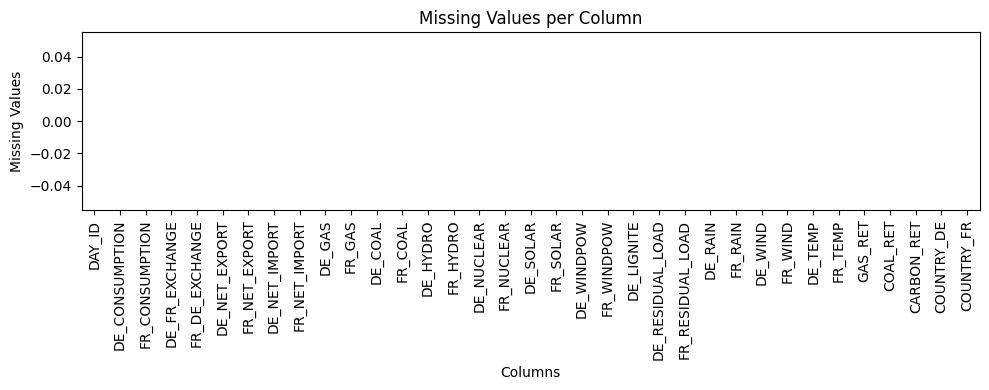

In [563]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

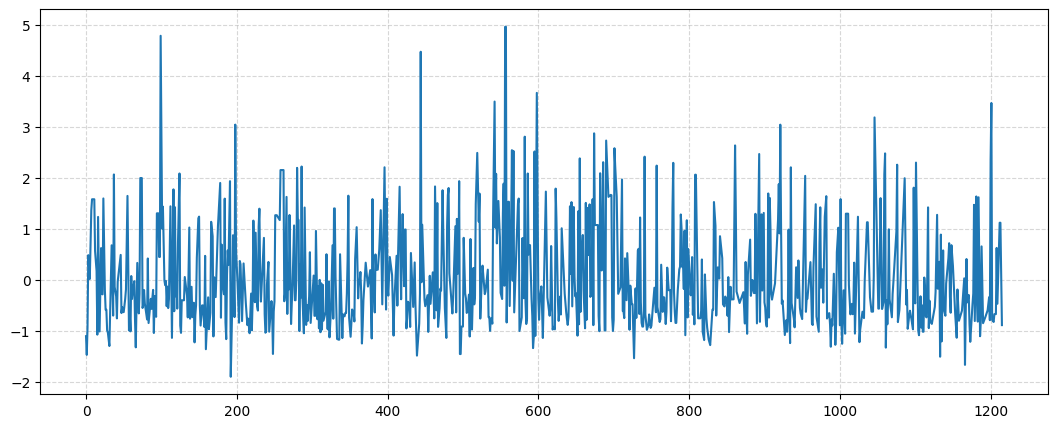

In [564]:
plot_ts(X['DAY_ID'], X['FR_WIND'])

# Fill Data

In [565]:
# Combined Training and Testing Data
# full_data = pd.concat([x_train, x_test], axis=0).sort_index()
# de_full_data = full_data[full_data['COUNTRY'] == 'DE']
# fr_full_data = full_data[full_data['COUNTRY'] == 'FR']

# x_train = x_train.interpolate(method='linear')
# x_test = x_test.interpolate(method='linear')

# Separating data for each country
# de_x_train = x_train[x_train['COUNTRY'] == 'DE']
# de_y_train = y_train[y_train.index.isin(de_x_train.index)]
# fr_x_train = x_train[x_train['COUNTRY'] == 'FR']
# fr_y_train = y_train[y_train.index.isin(fr_x_train.index)]

# XGBoost Regression

In [566]:
X_clean = X
Y_clean = y['TARGET']

In [567]:
CV_XGB_MSE = XGBRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.3s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END alpha=5, colsample_bytree=0.3, learning_rate

In [568]:
X_validation_clean = x_validation
cross_validated_model = pd.DataFrame()
cross_validated_model['ID'] = x_validation.index.to_list()
cross_validated_model['TARGET'] = CV_XGB_MSE['model'].predict(X_validation_clean)
cross_validated_model.to_csv('src/cross_validated_model.csv', index=False)

Current out of sample performance is 18.58%. This beats the benchmark Linear Regression Model's performance of 15.9%

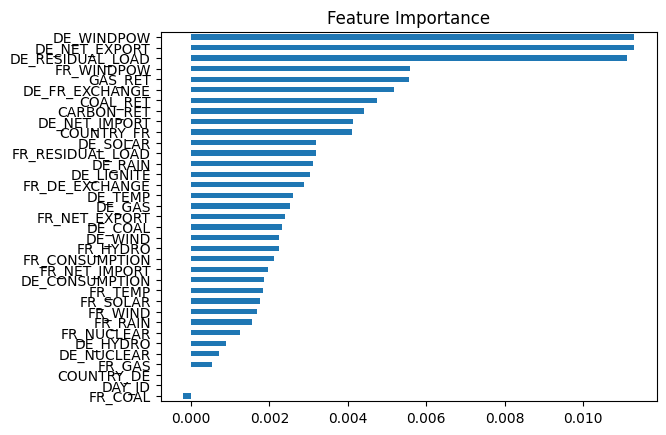

In [569]:
model = CV_XGB_MSE['model']
X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

# Perform permutation importance
results = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)

# Get importance scores
importance_scores = results.importances_mean

# Organize and plot the importance scores
importances = pd.Series(importance_scores, index=X_train.columns)
importances = importances.sort_values()

importances.plot(kind='barh')
plt.title('Feature Importance')
plt.show()

# Target Predictions that work better than mine

97.12128010347861
Model parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


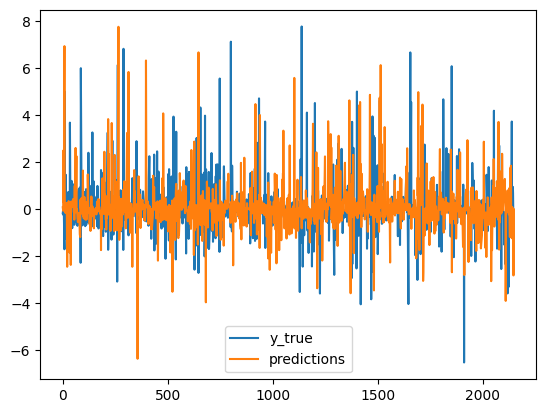

In [589]:
# Simple Model
xgb= XGBRegressor()
xgb.fit(X_clean, Y_clean)
predictions = xgb.predict(X_clean)
predictions_df = pd.DataFrame(predictions, index=y.index)
print(metric_train(predictions, Y_clean))
y = y.sort_index()
plt.plot(y['TARGET'], label='y_true')
plt.plot(predictions_df, label='predictions')
plt.legend()
print("Model parameters:", xgb.get_params())

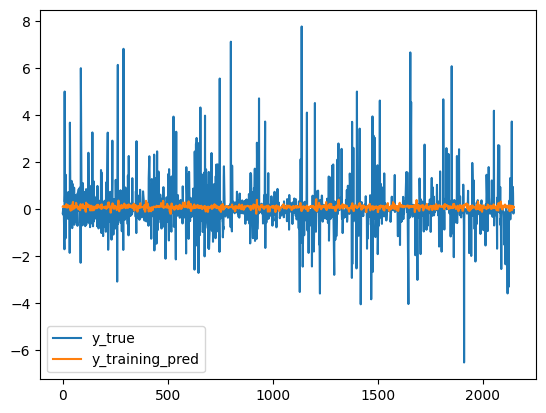

In [590]:
training_predictions = pd.DataFrame(CV_XGB_MSE['Training Prediction'], index=y.index)
plt.plot(y['TARGET'], label='y_true')
plt.plot(training_predictions, label='y_training_pred')
plt.legend()

In [537]:
cross_validated_model = cross_validated_model.sort_values(by='ID')
cross_validated_model.head()

,ID,TARGET
489,1,0.077326
296,6,0.112264
625,7,-0.005685
532,11,0.126918
430,16,0.225197


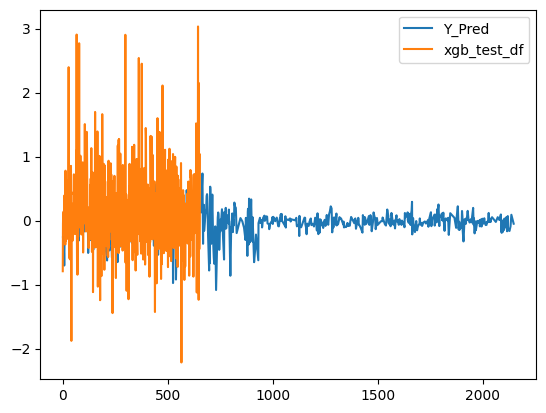

In [592]:
y_pred = pd.read_csv('src/y_pred.csv')
y_pred = y_pred.sort_values(by='ID')

xgb_test = xgb.predict(X_validation_clean)
xgb_test_df = pd.DataFrame(xgb_test, index=y_pred.index).sort_index()
plt.plot(y_pred['ID'], y_pred['TARGET'], label='Y_Pred')
plt.plot(xgb_test_df, label='xgb_test_df')
plt.legend()

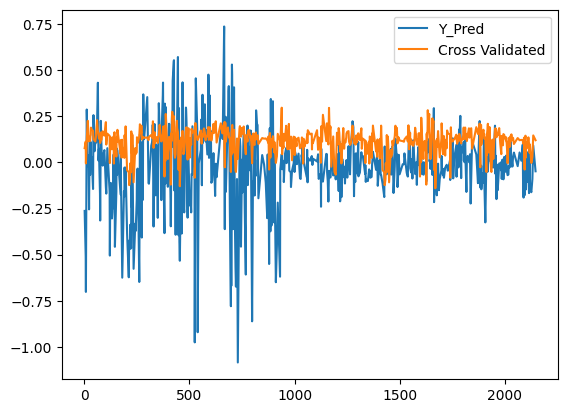

In [539]:
#plt.plot(full_model['ID'], full_model['TARGET'], label='Full Model')



plt.plot(y_pred['ID'], y_pred['TARGET'], label='Y_Pred')
plt.plot(cross_validated_model['ID'], cross_validated_model['TARGET'], label='Cross Validated')
plt.legend()

In [540]:
metric_train(cross_validated_model['TARGET'], y_pred['TARGET'])

50.611573140265975

In [542]:
prev_pred = pd.read_csv('src/xgb_predictions.csv')
prev_pred = prev_pred.sort_values(by='ID')
metric_train(prev_pred['TARGET'], cross_validated_model['TARGET'])

38.06143148281659

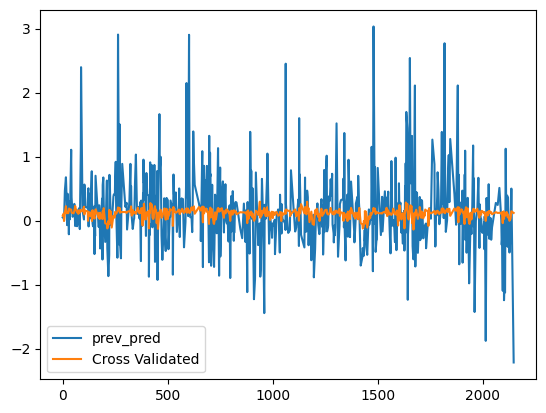

In [543]:
plt.plot(prev_pred['ID'], prev_pred['TARGET'], label='prev_pred')
plt.plot(cross_validated_model['ID'], cross_validated_model['TARGET'], label='Cross Validated')
plt.legend()

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

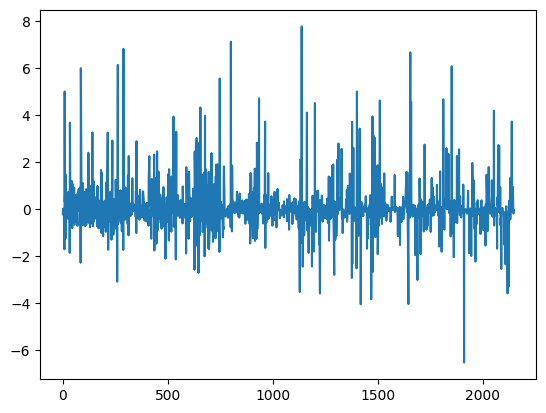

In [548]:
len(CV_XGB_MSE['Training Prediction'])

1494

In [549]:
len(y['TARGET'])

1494